## 1. Import Libraries and loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from collections import Counter


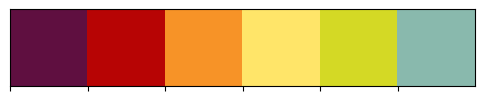

In [2]:
# custom color palette
my_colors = ["#5F0F40", "#B70404", "#F79327", "#FFE569", "#D4D925", "#89B9AD"]  

# Plot Color Palletes
sns.palplot(my_colors)

In [3]:
# read the dataset into a dataframe
df = pd.read_csv('../data/cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df.tail(5)

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


## 2. Basic info and statistics

In [5]:
# Display basic information about the dataset
print("\nBasic info about the dataset:")
print(df.info())


Basic info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB
None


In [6]:
# dataset shape: (rows, columns)
df.shape

(47692, 2)

In [7]:
# Display summary statistics of the dataset
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
                                               tweet_text cyberbullying_type
count                                               47692              47692
unique                                              46017                  6
top     RT @sailorhg: the intro for my hardware hackin...           religion
freq                                                    2               7998


## 3. Initial data cleaning

### 3.1 Handling null values

In [8]:
df.isna().any()

tweet_text            False
cyberbullying_type    False
dtype: bool

### 3.2 Handling duplicate values

In [9]:
# Check for duplicated rows based on all columns
duplicates = df.duplicated()

# Display the number of duplicated rows
print(f"\nNumber of duplicated rows: {duplicates.sum()}")

# View the duplicated rows
print("\nDuplicated rows:")
print(df[duplicates])


Number of duplicated rows: 36

Duplicated rows:
                                              tweet_text cyberbullying_type
1758   Our pancakes are selling like hotcakes Shaz - ...  not_cyberbullying
3833   But you all respect him....Pete hasn't read tw...  not_cyberbullying
3939   This is the opportunity to prove ourselves lik...  not_cyberbullying
5684   Strategicscoring should be classed as cheating...  not_cyberbullying
6975   If we're at the bottom of the leaderboard, we'...  not_cyberbullying
7227   It wouldn't be fair. Kat knows NOTHING of fair...  not_cyberbullying
7278   @TVWEEKmag: There is only 1 way to stay in the...  not_cyberbullying
7822   @Ima_TV_Junkie: What the hell were Annie and L...  not_cyberbullying
9672   @victorymonk: #sorryitsaboy joke means more bo...             gender
9835   @thisonesakillaa: In my opinion? All jokes are...             gender
11076  Simple things please simple minds. @pumpkinkin...             gender
12664  No offense. @NigelBigMeech I'm n

We have 36 rows that are duplicates.

In [10]:
# Remove duplicated rows and keep the first occurrence
df = df.drop_duplicates()
print(f"\nNumber of duplicated rows: {df.duplicated().sum()}")
print(df.shape)


Number of duplicated rows: 0
(47656, 2)


We have removed duplicated rows.

## 4. EDA

### 4.1 Class distribution

In [11]:
class_counts = df['cyberbullying_type'].value_counts()
print(class_counts)

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64


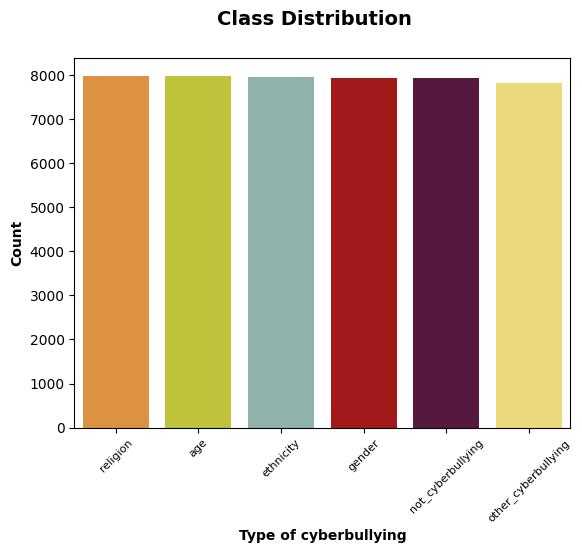

In [12]:
# plot the class distribution
sns.countplot(data=df, x=df["cyberbullying_type"], hue="cyberbullying_type", palette=my_colors, order=class_counts.index)
plt.suptitle('Class Distribution', 
             fontweight = 'heavy', fontsize = 14)
plt.xlabel('Type of cyberbullying', fontweight = 'heavy', fontsize = 10)
plt.ylabel('Count', fontweight = 'heavy', fontsize = 10)
# Adjust the x-axis labels
plt.xticks(fontsize=8, rotation=45) 
plt.show()

### 4.2 Tweets length analysis

In [13]:
# Length of the tweet texts
df['text_length'] = df['tweet_text'].apply(len)
print("\nSummary statistics of text length:")
print(df['text_length'].describe())


Summary statistics of text length:
count    47656.000000
mean       136.258519
std         85.061642
min          1.000000
25%         78.000000
50%        124.000000
75%        180.000000
max       4962.000000
Name: text_length, dtype: float64


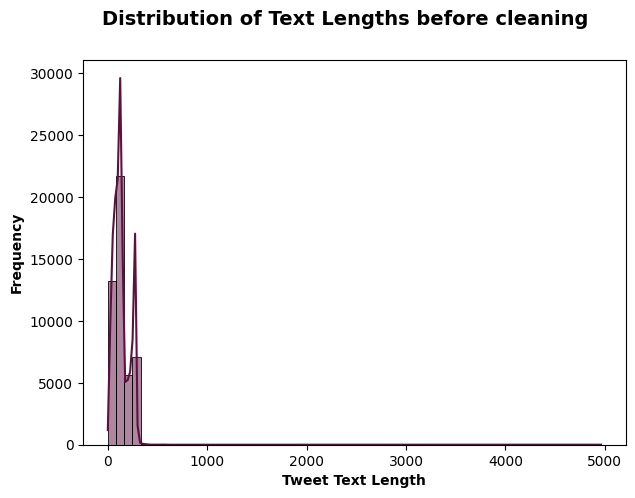

In [14]:
# Plot the distribution of text lengths
plt.figure(figsize=(7, 5))
sns.histplot(df['text_length'], bins=60, color= my_colors[0], kde=True)
plt.xlabel('Tweet Text Length', fontweight = 'heavy', fontsize = 10)
plt.ylabel('Frequency', fontweight = 'heavy', fontsize = 10)
plt.suptitle('Distribution of Text Lengths before cleaning', 
             fontweight = 'heavy', fontsize = 14)
plt.show()

There seems to be tweets character ranging up to 5000. So at the time when the data was collected, the character limit was set at 280. So lets filter the tweets that exceeds the character limit.

In [15]:
# Filter rows where the text length is greater than 280 characters
long_tweets = df[df['text_length'] > 280]

# Loop through each tweet in long_tweets and print it
print("\nTweets with more than 280 characters:")
for index, row in long_tweets.iterrows():
    print(f"Tweet {index + 1} (Length: {row['text_length']}):\n{row['tweet_text']}\n")
    print(f"Cyberbullying type: {row['cyberbullying_type']}")
    print("\n" + "-"*50 + "\n")


Tweets with more than 280 characters:
Tweet 1318 (Length: 1790):
@EurekAlertAAAS: Researchers push to import top anti-bullying program to US schools http://t.co/UPZrMbl
@NomCookiesNom Instead of personal attacks, maybe you can explain why there are more than 100 Islamic terrorist groups.
@_Finessinfool yea imma bring in tomorrow
#mkr I think Colin might not be a fan of the meatballs.
@KatieBatterman yeah, we should talk. I was just about to send an email over to them right before I was told it was retracted.
I'm not a fan of the bears from QLD. 💩 #MKR
@eDRoaCH @orvtech this isn't de-anonymizing. the phone # wouldn't necessarily be stored. no names would be required.
@owlcity hey adam :) I've been to 2 of your concerts &amp; haven't been allowed to meet you. when will I be able to?
Me: The boat or the thing that melts Nazi faces?
Watching a video of the snowman play from primary school! Go Tanners Wood haha #oldschool
@eranubuwah @352_7538 Taking tiny villages while loosing major citie

Looking at the long tweets, it is obvious that there is some mistakes in the data collection. Reasons can be:
* Some tweets might be part of conversations or twitter thread.
* Combined multiple tweets into one entry. (retweets or quoted tweets merged with original)

We can delete those extremely long tweets as they will be outliers.


Certain tweets having tweet length just above 280 charcaters. These are due to:
* urls
* HTML entities (eg: `&amp;` is the HTML entity for the &)

## 5. Data Cleaning and EDA

### 5.1 Removing rows containing more than 400 character

In [16]:
# Remove rows with more than 400 characters in the tweet
df = df[df['tweet_text'].apply(len) <= 400]

# Check the shape to see how many rows are remaining after the removal
print(f"Number of rows after removing tweets with more than 400 characters: {df.shape[0]}")

Number of rows after removing tweets with more than 400 characters: 47626


# Removing other_cyberbullying and not_cyberbullying 

These two classes are too generic. Also the class `other_cyberbullying` contains lots of mistakes. Most of them are not any kind of cyberbullying. So i am going to delete the `other_cyberbullying` class from the dataset.

In [17]:
filtered_df = df[df['cyberbullying_type'] != 'other_cyberbullying']

In [18]:
# Create a new DataFrame with preprocessed columns
filtered_df = filtered_df[['tweet_text', 'cyberbullying_type']]

Let's save the data to a csv file after our intial cleaning. We have deleted duplicated rows, checked for null values, and removed tweets having more than 400 characters.

In [19]:
filtered_df.to_csv('../data/cyberbullying_data(cleaned).csv', index=False)